In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import shapely
from shapely.geometry import Point
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import KFold

In [2]:
# Read in dataframe of all of our New York state GEDI L2A data.
# Thanks to Luke Kiernan for this particular loop.
allGranules = {fname : pd.read_csv(os.path.join('data', fname)) for fname in os.listdir('data')}
#for key, val in allGranules.items():
#    if val.empty:
#        del val
#        continue
#    val['rh_100'] = val['rh'].apply(lambda x : float(re.search(lastNum,x)[1]))
#    del val['rh']
#        val['granule'] = key.split('.')[0]

allData = pd.concat(item for item in allGranules.values() if not item.empty)

allData['timestamp'] = pd.to_datetime(allData['delta_time'],unit ='s', origin = pd.Timestamp('2018-01-01 00:00'))
allData['date'] = allData['timestamp'].dt.strftime('%Y-%m-%d').astype(str)

allData['geometry'] = allData.apply(lambda row: Point(row['lon_lowestmode'], row['lat_lowestmode']), axis=1)
allData.drop(['lon_lowestmode', 'lat_lowestmode', 'delta_time'], axis=1)

,Unnamed: 0,Class,Group,beam,channel,elev_lowestmode,rh,land_cover_data/landsat_water_persistence,land_cover_data/landsat_treecover,land_cover_data/region_class,land_cover_data/urban_proportion,land_cover_data/urban_focal_window_size,shot_number,timestamp,date,geometry
0,0,Deciduous Forest,Forest,2,1,405.33050,[-1.42 -1.34 -1.23 -1.16 -1.08 -0.97 -0.89 -0....,0,98.0,7,0,3,19710200300211816,2019-04-18 19:45:54.249271808,2019-04-18,POINT (-75.19103487246879 43.54245054508422)
1,1,Open Water,Water,3,1,394.07846,[-2.24 -2.13 -2.02 -1.91 -1.79 -1.72 -1.64 -1....,80,0.0,7,0,3,19710300300206949,2019-04-18 19:45:54.410419712,2019-04-18,POINT (-75.17965176792944 43.53067556171298)
2,2,Shrub/Scrub,Scrubland,5,2,226.34680,[-2.62 -2.54 -2.43 -2.32 -2.24 -2.17 -2.09 -2....,0,100.0,7,0,3,19710500300206503,2019-04-18 19:45:52.476531968,2019-04-18,POINT (-75.34908309962478 43.60124665622904)
3,3,Deciduous Forest,Forest,5,2,317.78790,[-2.47 -2.32 -2.17 -2.02 -1.87 -1.72 -1.57 -1....,0,85.0,7,0,3,19710500300206553,2019-04-18 19:45:52.889775104,2019-04-18,POINT (-75.31936565423234 43.58735642255881)
4,4,Evergreen Forest,Forest,5,2,330.49307,[-4.04 -3.67 -3.37 -3.1 -2.92 -2.73 -2.58 -2....,0,85.0,7,0,3,19710500300206623,2019-04-18 19:45:53.468267776,2019-04-18,POINT (-75.27773148454551 43.56785820426982)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,169,Woody Wetlands,Wetlands,11,5,494.27267,[-1.94 -1.45 -1.04 -0.59 -0.22 0.18 0.59 1....,0,87.0,7,0,3,186741100300208519,2022-03-31 01:20:15.676702208,2022-03-31,POINT (-74.57356006047097 44.06130197159184)
170,170,Woody Wetlands,Wetlands,11,5,495.51144,[-4.07 -3.7 -3.4 -3.17 -2.99 -2.8 -2.65 -2....,0,21.0,7,0,3,186741100300208529,2022-03-31 01:20:15.759362304,2022-03-31,POINT (-74.56751548063538 44.05859389836164)
171,171,Developed Open Space,Developed,11,5,494.57290,[-4.67 -4.07 -3.66 -3.36 -3.06 -2.8 -2.58 -2....,0,45.0,7,0,3,186741100300208539,2022-03-31 01:20:15.842022144,2022-03-31,POINT (-74.56147343671132 44.05588318942717)
172,172,Mixed Forest,Forest,11,5,507.23343,[-4.180e+00 -3.620e+00 -3.170e+00 -2.730e+00 -...,0,87.0,7,0,3,186741100300208549,2022-03-31 01:20:15.924669696,2022-03-31,POINT (-74.55542597651393 44.05316463516777)


In [3]:
allData.head()

,Unnamed: 0,Class,Group,beam,channel,lat_lowestmode,lon_lowestmode,elev_lowestmode,delta_time,rh,land_cover_data/landsat_water_persistence,land_cover_data/landsat_treecover,land_cover_data/region_class,land_cover_data/urban_proportion,land_cover_data/urban_focal_window_size,shot_number,timestamp,date,geometry
0,0,Deciduous Forest,Forest,2,1,43.542451,-75.191035,405.33050,4.085195e+07,[-1.42 -1.34 -1.23 -1.16 -1.08 -0.97 -0.89 -0....,0,98.0,7,0,3,19710200300211816,2019-04-18 19:45:54.249271808,2019-04-18,POINT (-75.19103487246879 43.54245054508422)
1,1,Open Water,Water,3,1,43.530676,-75.179652,394.07846,4.085195e+07,[-2.24 -2.13 -2.02 -1.91 -1.79 -1.72 -1.64 -1....,80,0.0,7,0,3,19710300300206949,2019-04-18 19:45:54.410419712,2019-04-18,POINT (-75.17965176792944 43.53067556171298)
2,2,Shrub/Scrub,Scrubland,5,2,43.601247,-75.349083,226.34680,4.085195e+07,[-2.62 -2.54 -2.43 -2.32 -2.24 -2.17 -2.09 -2....,0,100.0,7,0,3,19710500300206503,2019-04-18 19:45:52.476531968,2019-04-18,POINT (-75.34908309962478 43.60124665622904)
3,3,Deciduous Forest,Forest,5,2,43.587356,-75.319366,317.78790,4.085195e+07,[-2.47 -2.32 -2.17 -2.02 -1.87 -1.72 -1.57 -1....,0,85.0,7,0,3,19710500300206553,2019-04-18 19:45:52.889775104,2019-04-18,POINT (-75.31936565423234 43.58735642255881)
4,4,Evergreen Forest,Forest,5,2,43.567858,-75.277731,330.49307,4.085195e+07,[-4.04 -3.67 -3.37 -3.1 -2.92 -2.73 -2.58 -2....,0,85.0,7,0,3,19710500300206623,2019-04-18 19:45:53.468267776,2019-04-18,POINT (-75.27773148454551 43.56785820426982)


In [4]:
# PRODUCE RH METRIC ARRAY
def str2np(rhstr):
    return np.fromstring(rhstr[1:-1], sep=' ')
    
rh = np.array([str2np(r) for r in allData["rh"]])
rh

array([[-1.42, -1.34, -1.23, ...,  3.85,  3.97,  4.11],
       [-2.24, -2.13, -2.02, ...,  2.05,  2.17,  2.32],
       [-2.62, -2.54, -2.43, ...,  2.28,  2.39,  2.5 ],
       ...,
       [-4.67, -4.07, -3.66, ..., 10.5 , 10.99, 11.66],
       [-4.18, -3.62, -3.17, ..., 29.88, 30.44, 31.07],
       [-4.15, -3.7 , -3.36, ..., 14.47, 15.07, 15.96]])

In [5]:
# Just choose every 10 for now.
# THERE HAS TO BE SOME MORE EFFICIENT WAY TO DO THIS, MAYBE USING pd.concat?

col_names = [('rh_' + str(i)) for i in range(0,101,10)]

i = 0
for col in col_names:

    allData[col] = rh[:,i]

    i = i + 10

In [6]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738916 entries, 0 to 173
Data columns (total 30 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Unnamed: 0                                 738916 non-null  int64         
 1   Class                                      738916 non-null  object        
 2   Group                                      738916 non-null  object        
 3   beam                                       738916 non-null  int64         
 4   channel                                    738916 non-null  int64         
 5   lat_lowestmode                             738916 non-null  float64       
 6   lon_lowestmode                             738916 non-null  float64       
 7   elev_lowestmode                            738916 non-null  float64       
 8   delta_time                                 738916 non-null  float64       
 9   rh          

In [7]:
# Add an additional column assigning numbers to each of the classes, to ease model training.
allData['Class_num'] = 0

#Open Water == 0 -- assign the rest
allData.loc[allData.Class=='Developed Open Space', 'Class_num'] = 1
allData.loc[allData.Class=='Developed Low Intensity', 'Class_num'] = 2
allData.loc[allData.Class=='Developed Medium Intensity', 'Class_num'] = 3
allData.loc[allData.Class=='Developed High Intensity', 'Class_num'] = 4
allData.loc[allData.Class=='Barren Land (Rock/Sand/Clay)', 'Class_num'] = 5
allData.loc[allData.Class=='Deciduous Forest', 'Class_num'] = 6
allData.loc[allData.Class=='Evergreen Forest', 'Class_num'] = 7
allData.loc[allData.Class=='Mixed Forest', 'Class_num'] = 8
allData.loc[allData.Class=='Grassland/Herbaceous', 'Class_num'] = 9
allData.loc[allData.Class=='Shrub/Scrub', 'Class_num'] = 10
allData.loc[allData.Class=='Pasture/Hay', 'Class_num'] = 11
allData.loc[allData.Class=='Cultivated Crops', 'Class_num'] = 12
allData.loc[allData.Class=='Woody Wetlands', 'Class_num'] = 13
allData.loc[allData.Class=='Emergent Herbaceous Wetlands', 'Class_num'] = 14


In [8]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738916 entries, 0 to 173
Data columns (total 31 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Unnamed: 0                                 738916 non-null  int64         
 1   Class                                      738916 non-null  object        
 2   Group                                      738916 non-null  object        
 3   beam                                       738916 non-null  int64         
 4   channel                                    738916 non-null  int64         
 5   lat_lowestmode                             738916 non-null  float64       
 6   lon_lowestmode                             738916 non-null  float64       
 7   elev_lowestmode                            738916 non-null  float64       
 8   delta_time                                 738916 non-null  float64       
 9   rh          

In [9]:
# Add one more column for each different Group for model training.
allData['Group_num'] = 0

#Water == 0 -- assign the rest
allData.loc[allData.Group=='Developed', 'Group_num'] = 1
allData.loc[allData.Group=='Barren', 'Group_num'] = 2
allData.loc[allData.Group=='Forest', 'Group_num'] = 3
allData.loc[allData.Group=='Scrubland', 'Group_num'] = 4
allData.loc[allData.Group=='Planted/Cultivated', 'Group_num'] = 5
allData.loc[allData.Group=='Wetlands', 'Group_num'] = 6
allData.loc[allData.Group=='Not Classified', 'Group_num'] = 7


In [10]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738916 entries, 0 to 173
Data columns (total 32 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Unnamed: 0                                 738916 non-null  int64         
 1   Class                                      738916 non-null  object        
 2   Group                                      738916 non-null  object        
 3   beam                                       738916 non-null  int64         
 4   channel                                    738916 non-null  int64         
 5   lat_lowestmode                             738916 non-null  float64       
 6   lon_lowestmode                             738916 non-null  float64       
 7   elev_lowestmode                            738916 non-null  float64       
 8   delta_time                                 738916 non-null  float64       
 9   rh          

In [11]:
# One simpler, four-class idea: Developed, Barren, Vegetated, or Not Classified.
allData['Veg_Class'] = 0

#Developed == 0 -- assign the rest
allData.loc[allData.Group=='Barren', 'Group_num'] = 1
allData.loc[allData.Group=='Forest', 'Group_num'] = 2
allData.loc[allData.Group=='Scrubland', 'Group_num'] = 2
allData.loc[allData.Group=='Planted/Cultivated', 'Group_num'] = 2
allData.loc[allData.Group=='Wetlands', 'Group_num'] = 2
allData.loc[allData.Group=='Not Classified', 'Group_num'] = 3

In [12]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 738916 entries, 0 to 173
Data columns (total 33 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Unnamed: 0                                 738916 non-null  int64         
 1   Class                                      738916 non-null  object        
 2   Group                                      738916 non-null  object        
 3   beam                                       738916 non-null  int64         
 4   channel                                    738916 non-null  int64         
 5   lat_lowestmode                             738916 non-null  float64       
 6   lon_lowestmode                             738916 non-null  float64       
 7   elev_lowestmode                            738916 non-null  float64       
 8   delta_time                                 738916 non-null  float64       
 9   rh          

## Let's try an LDA model, trying to predict Class/Group from the various rh features.

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
allData

,Unnamed: 0,Class,Group,beam,channel,lat_lowestmode,lon_lowestmode,elev_lowestmode,delta_time,rh,...,rh_40,rh_50,rh_60,rh_70,rh_80,rh_90,rh_100,Class_num,Group_num,Veg_Class
0,0,Deciduous Forest,Forest,2,1,43.542451,-75.191035,405.33050,4.085195e+07,[-1.42 -1.34 -1.23 -1.16 -1.08 -0.97 -0.89 -0....,...,1.04,1.49,1.94,2.32,2.73,3.22,4.11,6,2,0
1,1,Open Water,Water,3,1,43.530676,-75.179652,394.07846,4.085195e+07,[-2.24 -2.13 -2.02 -1.91 -1.79 -1.72 -1.64 -1....,...,-0.22,0.03,0.33,0.63,1.01,1.49,2.32,0,0,0
2,2,Shrub/Scrub,Scrubland,5,2,43.601247,-75.349083,226.34680,4.085195e+07,[-2.62 -2.54 -2.43 -2.32 -2.24 -2.17 -2.09 -2....,...,-0.37,-0.03,0.33,0.74,1.23,1.76,2.50,10,2,0
3,3,Deciduous Forest,Forest,5,2,43.587356,-75.319366,317.78790,4.085195e+07,[-2.47 -2.32 -2.17 -2.02 -1.87 -1.72 -1.57 -1....,...,1.19,1.76,2.28,2.92,3.74,4.79,6.36,6,2,0
4,4,Evergreen Forest,Forest,5,2,43.567858,-75.277731,330.49307,4.085195e+07,[-4.04 -3.67 -3.37 -3.1 -2.92 -2.73 -2.58 -2....,...,0.03,0.59,1.31,2.35,18.57,24.79,27.38,7,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,169,Woody Wetlands,Wetlands,11,5,44.061302,-74.573560,494.27267,1.339248e+08,[-1.94 -1.45 -1.04 -0.59 -0.22 0.18 0.59 1....,...,12.64,14.88,16.68,18.40,20.04,21.95,25.88,13,2,0
170,170,Woody Wetlands,Wetlands,11,5,44.058594,-74.567515,495.51144,1.339248e+08,[-4.07 -3.7 -3.4 -3.17 -2.99 -2.8 -2.65 -2....,...,-0.48,-0.07,0.33,0.74,1.27,1.98,4.37,13,2,0
171,171,Developed Open Space,Developed,11,5,44.055883,-74.561473,494.57290,1.339248e+08,[-4.67 -4.07 -3.66 -3.36 -3.06 -2.8 -2.58 -2....,...,0.37,1.04,1.86,3.06,5.27,7.96,11.66,1,1,0
172,172,Mixed Forest,Forest,11,5,44.053165,-74.555426,507.23343,1.339248e+08,[-4.180e+00 -3.620e+00 -3.170e+00 -2.730e+00 -...,...,6.58,10.09,16.23,20.60,23.78,26.70,31.07,8,2,0


In [15]:
allData_train, allData_test = train_test_split(allData.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1)

In [58]:
features = allData_train.iloc[:, 19:20]
features
## Noah, I first just took 1 column for simplicity/testing. To get all the relevant rh columns, do features = allData_train.iloc[:, 19:30]

,rh_0
3142,-6.40
655,-5.27
1928,-7.26
1738,-4.30
915,-3.10
...,...
844,-4.34
4429,-10.41
2438,-7.04
13,-2.58


In [34]:
allData_train["Group_num"]

3142    2
655     2
1928    2
1738    2
915     2
       ..
844     1
4429    2
2438    2
13      0
520     0
Name: Group_num, Length: 665024, dtype: int64

In [40]:
n_splits=5
kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=216)

In [35]:
## Make the model object
LDA = LinearDiscriminantAnalysis()

## Fit the object 
LDA.fit(allData_train.iloc[:, 19:20], allData_train["Group_num"])


LinearDiscriminantAnalysis()

In [ ]:
## Noah, the LDA was fitted in the cell above. After this is a hodgepodge of stuff, most of which is probably not relevant

In [36]:
LDA.predict_proba(allData_train.iloc[:, 19:20])

array([[3.91398579e-02, 8.61317732e-02, 8.74246927e-01, 4.81441580e-04],
       [6.22351319e-02, 9.45747265e-02, 8.42370839e-01, 8.19302204e-04],
       [2.72991531e-02, 7.96298007e-02, 8.92752161e-01, 3.18885121e-04],
       ...,
       [2.99493203e-02, 8.12842347e-02, 8.88411948e-01, 3.54496808e-04],
       [1.73837199e-01, 1.09416222e-01, 7.14056660e-01, 2.68991883e-03],
       [1.76919602e-01, 1.09546801e-01, 7.10787745e-01, 2.74585135e-03]])

In [20]:
## defining the discriminant function
def delta_c(x, mu_hat, sigma_hat_sq, pi_c):
    return x*(mu_hat/sigma_hat_sq) - mu_hat**2/(2*sigma_hat_sq) + np.log(pi_c)

In [ ]:
X_train.loc[y_train==0].petal_length

In [51]:
features.loc[allData_train["Group_num"]==0]

,rh_0
44,-2.17
458,-2.20
1432,-2.95
1217,-3.59
135,-4.38
...,...
10,-3.25
440,-4.38
3249,-2.80
13,-2.58


In [55]:
## First we estimate the means of the three normal distributions
mu_0_hat = np.mean(features.loc[allData_train["Group_num"]==0])
mu_1_hat = np.mean(features.loc[allData_train["Group_num"]==1])
mu_2_hat = np.mean(features.loc[allData_train["Group_num"]==2])
mu_3_hat = np.mean(features.loc[allData_train["Group_num"]==3])
mu_4_hat = np.mean(features.loc[allData_train["Group_num"]==4])
mu_5_hat = np.mean(features.loc[allData_train["Group_num"]==5])
mu_6_hat = np.mean(features.loc[allData_train["Group_num"]==6])
mu_7_hat = np.mean(features.loc[allData_train["Group_num"]==7])

## Then the common variance

#sigma_hat_sq = np.sum(np.power(X_train.loc[y_train==0].petal_length - mu_0_hat,2))


sigma_hat_sq = np.sum(np.power(features.loc[allData_train["Group_num"]==0] - mu_0_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(features.loc[allData_train["Group_num"]==1] - mu_1_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(features.loc[allData_train["Group_num"]==2] - mu_2_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(features.loc[allData_train["Group_num"]==3] - mu_3_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(features.loc[allData_train["Group_num"]==4] - mu_4_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(features.loc[allData_train["Group_num"]==5] - mu_5_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(features.loc[allData_train["Group_num"]==6] - mu_6_hat,2))
sigma_hat_sq = sigma_hat_sq + np.sum(np.power(features.loc[allData_train["Group_num"]==7] - mu_7_hat,2))
sigma_hat_sq = sigma_hat_sq/(len(allData_train["Group_num"])-3)

C:\Users\17343\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


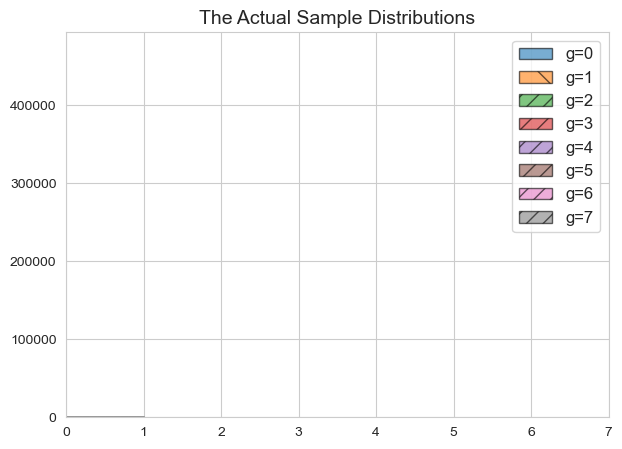

In [56]:
## Plot the sample distributions
plt.figure(figsize=(7,5))

plt.hist(features.loc[allData_train["Group_num"]==0],alpha=.6, 
         label="g=0",
         edgecolor="black")
plt.hist(features.loc[allData_train["Group_num"]==1],alpha=.6, 
         label="g=1",
         hatch = "\\",
         edgecolor="black")
plt.hist(features.loc[allData_train["Group_num"]==2],alpha=.6, 
         label="g=2",
         hatch='//',
         edgecolor="black")
plt.hist(features.loc[allData_train["Group_num"]==3],alpha=.6, 
         label="g=3",
         hatch='//',
         edgecolor="black")
plt.hist(features.loc[allData_train["Group_num"]==4],alpha=.6, 
         label="g=4",
         hatch='//',
         edgecolor="black")
plt.hist(features.loc[allData_train["Group_num"]==5],alpha=.6, 
         label="g=5",
         hatch='//',
         edgecolor="black")
plt.hist(features.loc[allData_train["Group_num"]==6],alpha=.6, 
         label="g=6",
         hatch='//',
         edgecolor="black")
plt.hist(features.loc[allData_train["Group_num"]==7],alpha=.6, 
         label="g=7",
         hatch='//',
         edgecolor="black")

plt.legend(fontsize=12)
plt.title("The Actual Sample Distributions", fontsize=14)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0,7)

plt.show()

In [26]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [27]:
l2a_train, l2a_test = train_test_split(allData.copy(),
                                            test_size=.2,
                                            random_state=514,
                                            shuffle=True)

In [28]:
n_splits = 5

kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=514)

In [18]:
ks = range(1, 56)
features = ['rh_0', 'rh_10', 'rh_20', 'rh_30', 'rh_40', 'rh_50', 'rh_60', 'rh_70', 'rh_80', 'rh_90', 'rh_100']

k_all_accs = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(l2a_train, l2a_train.Class_num):
    l2a_tt = l2a_train.iloc[train_index]
    l2a_ho = l2a_train.iloc[test_index]
    
    j = 0
    for k in ks:
        print(k)
        knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(k))])
        
        knn.fit(l2a_tt[features].values,
                   l2a_tt.Class_num.values)
        
        pred = knn.predict(l2a_ho[features].values)
        
        k_all_accs[i,j] = accuracy_score(l2a_ho.Class_num.values, pred)
        
        j = j + 1
    i = i + 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


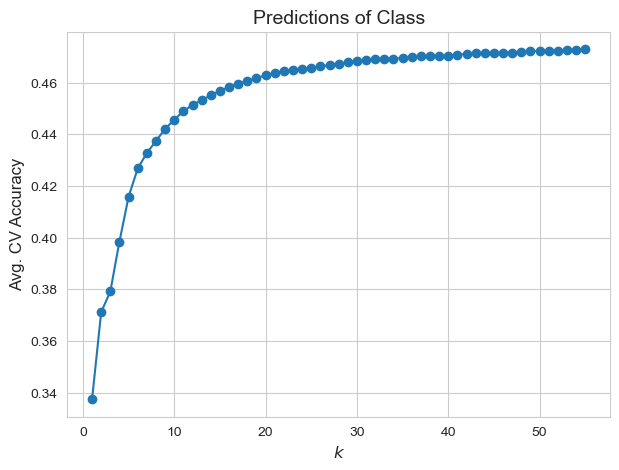

In [19]:
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Predictions of Class', fontsize=14)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

## There are many different Class names, and much fewer Group. Let's see how a kNN model performs when using Group at the predicted feature instead. Again, use the rh metrics.

In [21]:
ks = range(1, 56)
features = ['rh_0', 'rh_10', 'rh_20', 'rh_30', 'rh_40', 'rh_50', 'rh_60', 'rh_70', 'rh_80', 'rh_90', 'rh_100']

k_all_accs_group = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(l2a_train, l2a_train.Group_num):
    l2a_tt = l2a_train.iloc[train_index]
    l2a_ho = l2a_train.iloc[test_index]
    
    j = 0
    for k in ks:
        print(k)
        knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(k))])
        
        knn.fit(l2a_tt[features].values,
                   l2a_tt.Group_num.values)
        
        pred = knn.predict(l2a_ho[features].values)
        
        k_all_accs_group[i,j] = accuracy_score(l2a_ho.Group_num.values, pred)
        
        j = j + 1
    i = i + 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


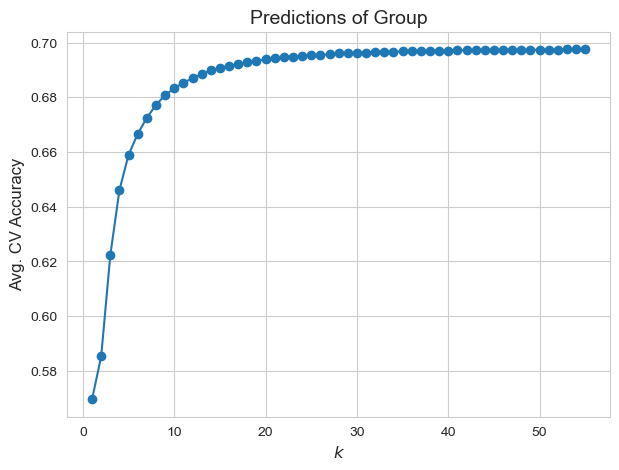

In [22]:
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_all_accs_group, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Predictions of Group', fontsize=14)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

In [30]:
# One more with only four Group labels instead of eight (see groupings above), 'Veg_Class'.
ks = range(1, 30)
features = ['rh_0', 'rh_10', 'rh_20', 'rh_30', 'rh_40', 'rh_50', 'rh_60', 'rh_70', 'rh_80', 'rh_90', 'rh_100']

k_all_accs_veg = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(l2a_train, l2a_train.Veg_Class):
    l2a_tt = l2a_train.iloc[train_index]
    l2a_ho = l2a_train.iloc[test_index]
    
    j = 0
    for k in ks:
        print(k)
        knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(k))])
        
        knn.fit(l2a_tt[features].values,
                   l2a_tt.Veg_Class.values)
        
        pred = knn.predict(l2a_ho[features].values)
        
        k_all_accs_veg[i,j] = accuracy_score(l2a_ho.Veg_Class.values, pred)
        
        j = j + 1
    i = i + 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


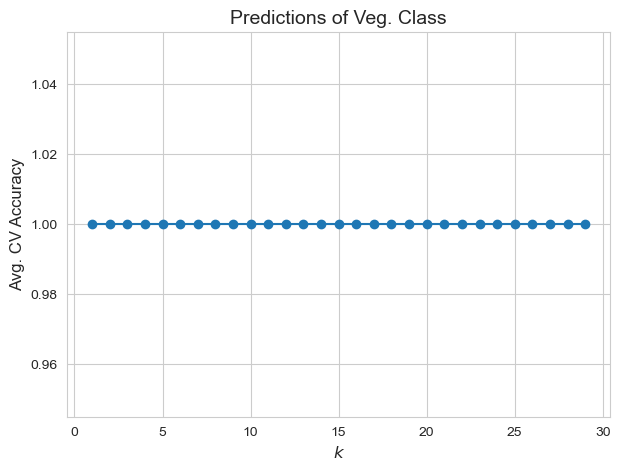

In [31]:
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_all_accs_veg, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Predictions of Veg. Class', fontsize=14)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()